## Predictive classification of female children's nutritional status based on their age and height


## Introduction:

The WHO defines stunted growth in children as a "height-for-age two standard deviations below the median" (*Stunting in a Nutshell*, 2015). Utilizing the "Stunting Baby/Toddler Detection" dataset with four nutritional statuses—severely stunted, stunted, normal, and tall—our research will analyze 60,000 cases focusing on females to predict a child's nutritional status from their age and height to design a reliable prediction model.


The research question of the project is: 
	Can we predict the nutritional status of a child based on age and height?


## Preliminary exploratory data analysis:

In [1]:
library(tidyverse)
library(dplyr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url = "https://raw.githubusercontent.com/nmahaj03/DSCI-100_Grp30_Project/main/GrowthStatus%20Dataset.csv"
download.file(url, "GrowthStatus Dataset.csv")
growth_data = read_csv("GrowthStatus Dataset.csv") 
colnames(growth_data) <- c('Age_Months','Sex','Height_cm', 'Nutritional_Status')
write_csv(growth_data,"GrowthStatus Dataset.csv")

Rows: 120999 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Sex, Nutritional_Status
dbl (2): Age_Months, Height_cm

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**We Subset the data pertaining to females and Store it in GrowthStatusFemale Dataset.csv.**

In [3]:
set.seed(1234)
growth_data_female = growth_data |>
                        filter(Sex == "Female") |>
                        mutate(Nutritional_Status = as_factor(Nutritional_Status))

growth_data_female = growth_data_female |>
                            sample_frac(0.04, replace = FALSE)

growth_data_female

write_csv(growth_data_female,"GrowthStatusFemale Dataset.csv")

Age_Months Sex    Height_cm Nutritional_Status
1    40         Female 105.7     normal            
2    40         Female 111.6     Tall              
3    41         Female 113.9     Tall              
⋮    ⋮          ⋮      ⋮         ⋮                 
2438 35         Female 92.6      normal            
2439  9         Female 80.4      Tall              
2440 48         Female 96.1      normal

****The dataset is split into Training and Testing dataframes.****

In [4]:
set.seed(3456) 
growth_data_fem_split <- initial_split(growth_data_female, prop = 0.70, strata = Nutritional_Status)  

growth_data_fem_split

<Training/Testing/Total>
<1706/734/2440>

In [5]:
growth_data_fem_train <- training(growth_data_fem_split)
growth_data_fem_test <- testing(growth_data_fem_split)

**First few rows of the training dataset presented using the glimpse function.**

In [6]:
#Structure of the training dataset obtained using the glimpse function.
glimpse(growth_data_fem_train)

Rows: 1,706
Columns: 4
$ Age_Months         <dbl> 40, 17, 19, 59, 32, 31, 50, 33, 55, 2, 46, 33, 51, …
$ Sex                <chr> "Female", "Female", "Female", "Female", "Female", "…
$ Height_cm          <dbl> 105.70000, 76.40000, 86.20000, 109.10000, 88.90000,…
$ Nutritional_Status <fct> normal, normal, normal, normal, normal, normal, nor…


**The Summary Function provides the Statistical Summary of the Dataset.**

In [7]:
#The Summary Function provides the Statistical Summary of the Dataset.
summary(growth_data_fem_train)

   Age_Months     Sex              Height_cm             Nutritional_Status
 Min.   : 0   Length:1706        Min.   : 40.52   severely stunted:255     
 1st Qu.:15   Class :character   1st Qu.: 75.80   Tall            :283     
 Median :30   Mode  :character   Median : 88.65   stunted         :224     
 Mean   :30                      Mean   : 88.08   normal          :944     
 3rd Qu.:45                      3rd Qu.:100.80                            
 Max.   :60                      Max.   :127.10                            

**Obtaining the means of Predictors grouped by Nutritional Status.**

In [8]:
growth_data_fem_train_mean = growth_data_fem_train |>
                            group_by(Nutritional_Status) |>
                            summarize(mean_Age = mean(Age_Months),
                                      mean_Height = mean(Height_cm))
growth_data_fem_train_mean

Nutritional_Status mean_Age mean_Height
1 severely stunted   25.24314 71.81832   
2 Tall               23.96466 94.69261   
3 stunted            33.70089 82.41936   
4 normal             32.21610 91.83126

**Obtaining Distributions of the class to be predicted.**

In [9]:
#Obtaining Distributions of the class to be predicted.
nutrition_proportions <- growth_data_fem_train |>
                      group_by(Nutritional_Status) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(growth_data_fem_train))


nutrition_proportions

Nutritional_Status n   percent 
1 severely stunted   255 14.94725
2 Tall               283 16.58851
3 stunted            224 13.13013
4 normal             944 55.33411

**Standardizing the data and preprocessing by scaling it.**

In [10]:
#Standardizing the data.
growth_recipe <- recipe(Nutritional_Status ~ Height_cm + Age_Months, data = growth_data_fem_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |> 
  prep()

In [11]:
#Preprocessing the data by scaling it.

scaled_growth_data_fem_train <- bake(growth_recipe, growth_data_fem_train)
scaled_growth_data_fem_train

Height_cm   Age_Months Nutritional_Status
1     1.0164760   0.5701602 normal            
2    -0.6736839  -0.7412083 normal            
3    -0.1083744  -0.6271762 normal            
⋮    ⋮           ⋮          ⋮                 
1704  1.62793317  0.8552403 Tall              
1705 -0.07376364 -0.9692723 Tall              
1706 -0.44294532 -1.1973364 Tall

**Scatterplot of the unscaled training data.**

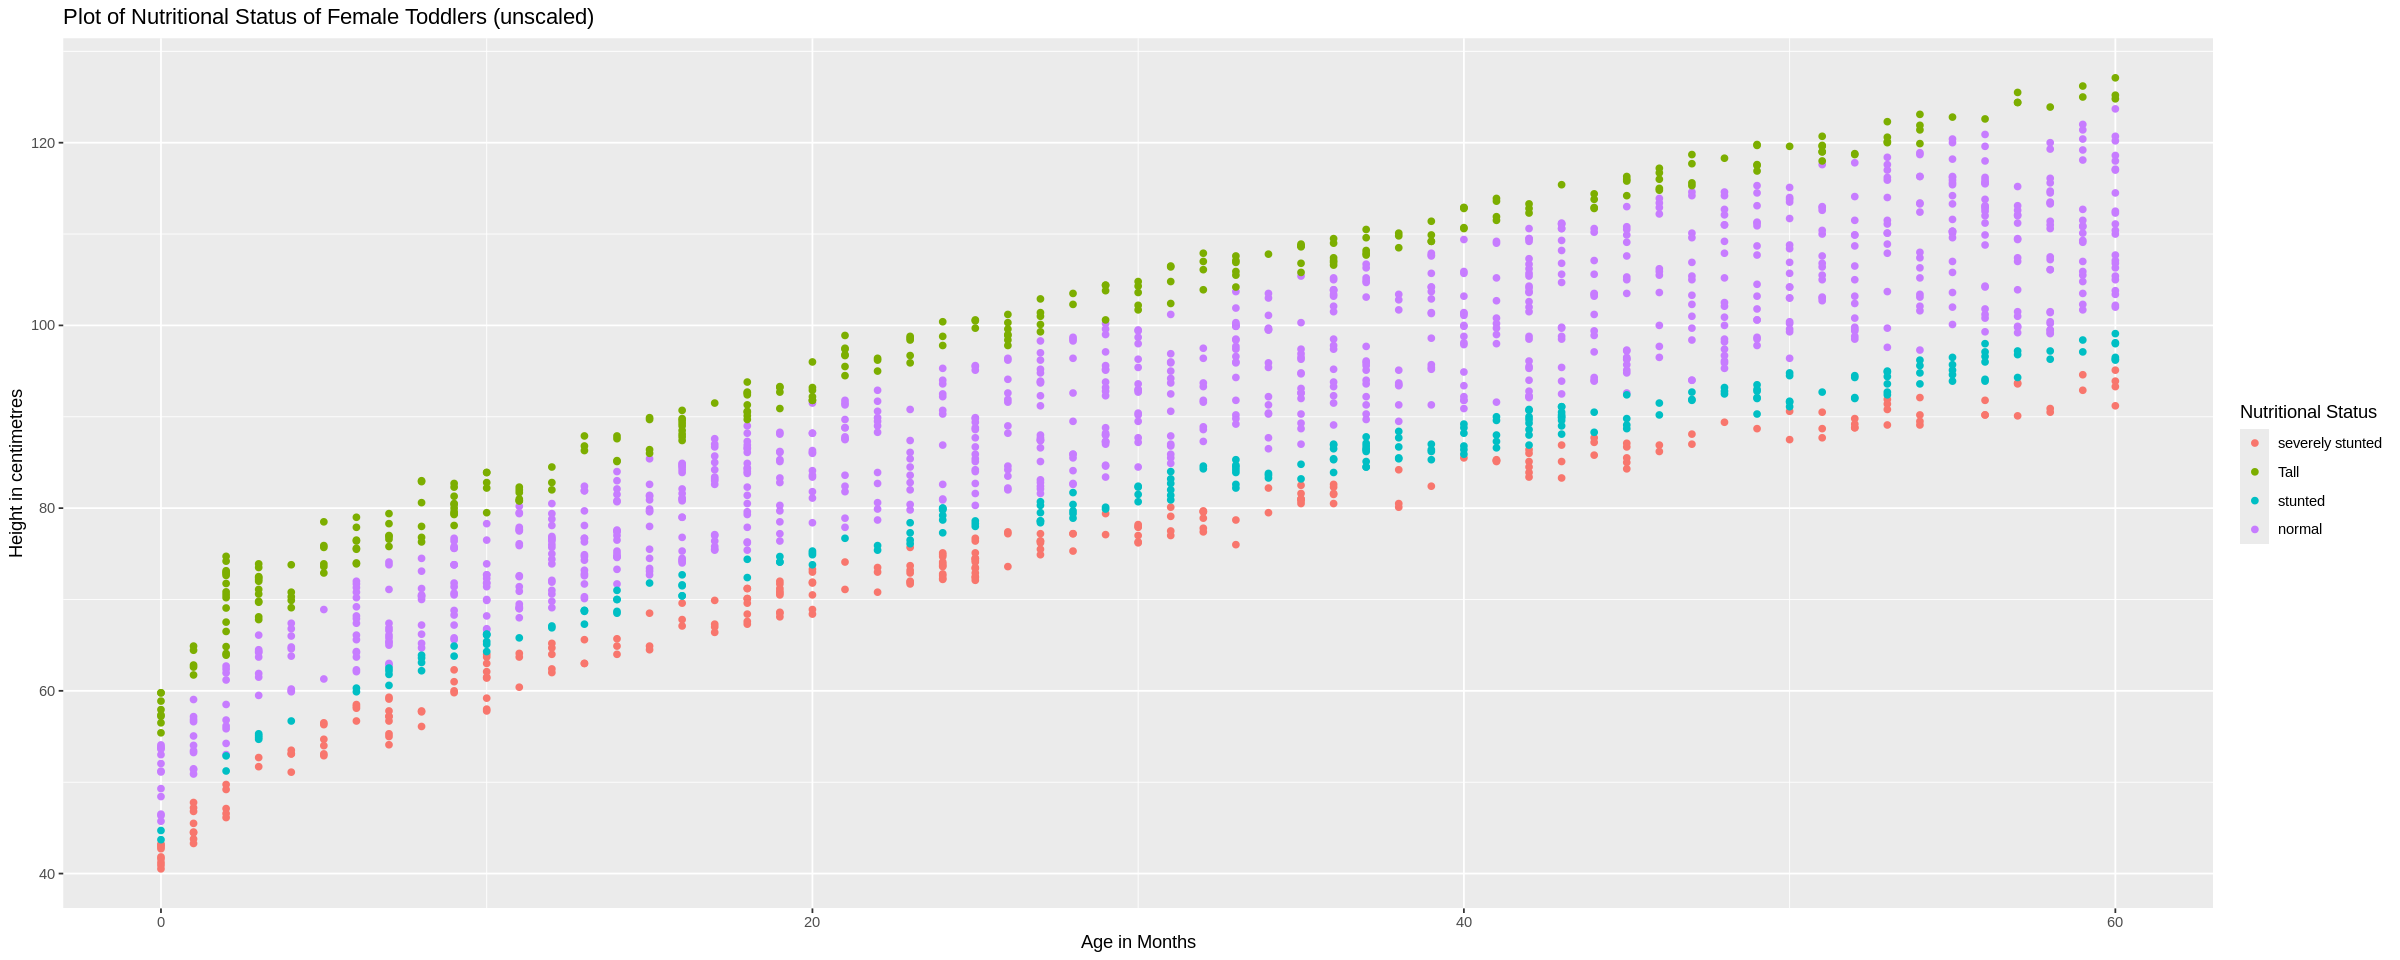

In [12]:

options(repr.plot.width = 20, repr.plot.height = 8)
unscaled_fem_growth_plot <- growth_data_fem_train|>
                            ggplot(aes(x = Age_Months, y= Height_cm, color= Nutritional_Status))+
                            geom_point() +
                            labs(x= "Age in Months", y= "Height in centimetres",color = "Nutritional Status")+
                            ggtitle("Plot of Nutritional Status of Female Toddlers (unscaled)")

unscaled_fem_growth_plot

**Scatterplot of the scaled training data.**

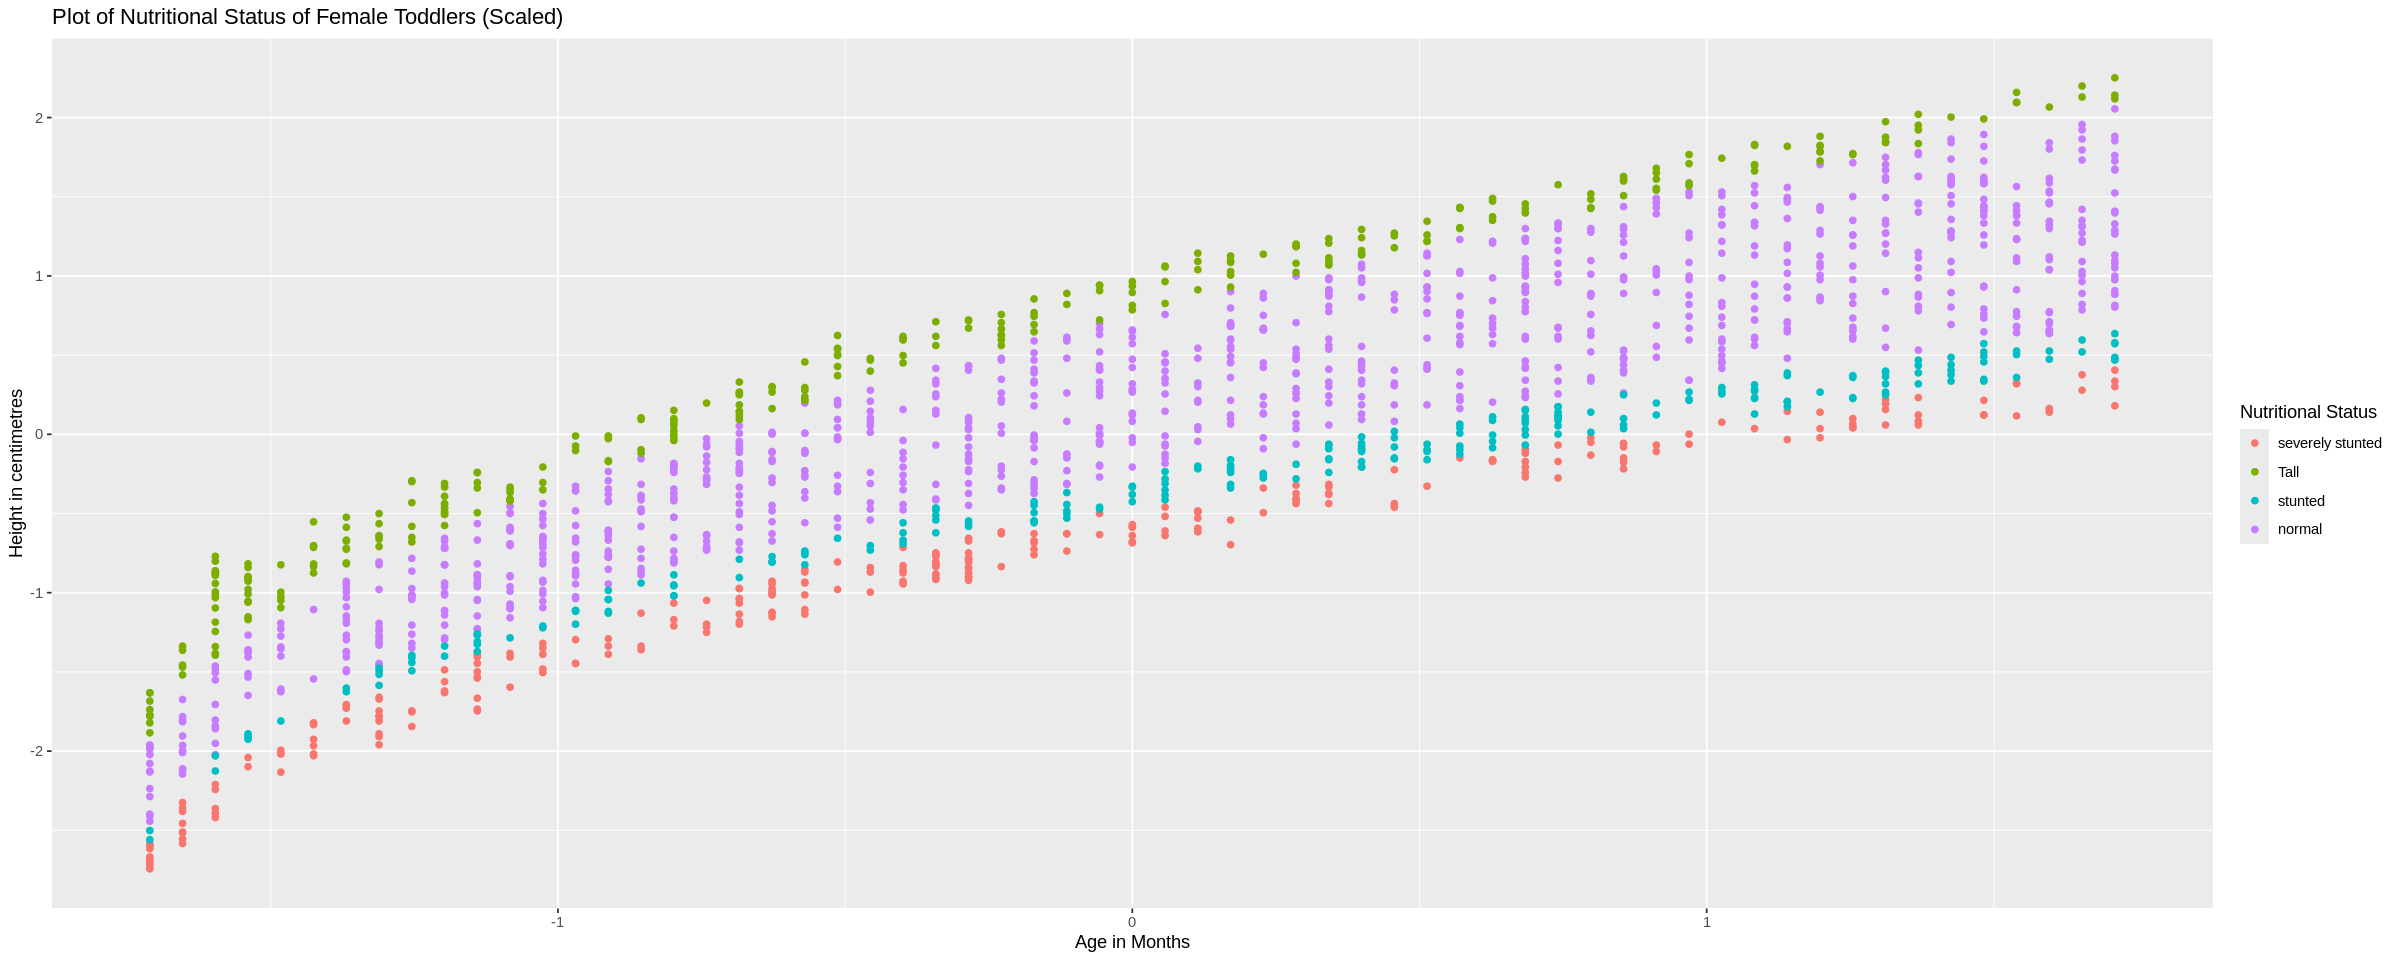

In [13]:

options(repr.plot.width = 20, repr.plot.height = 8)
scaled_fem_growth_plot <- scaled_growth_data_fem_train|>
                            ggplot(aes(x = Age_Months, y= Height_cm, color= Nutritional_Status))+
                            geom_point() +
                            labs(x= "Age in Months", y= "Height in centimetres",color = "Nutritional Status")+
                            ggtitle("Plot of Nutritional Status of Female Toddlers (Scaled)")

scaled_fem_growth_plot

**Histogram of the data distribution by Age.**

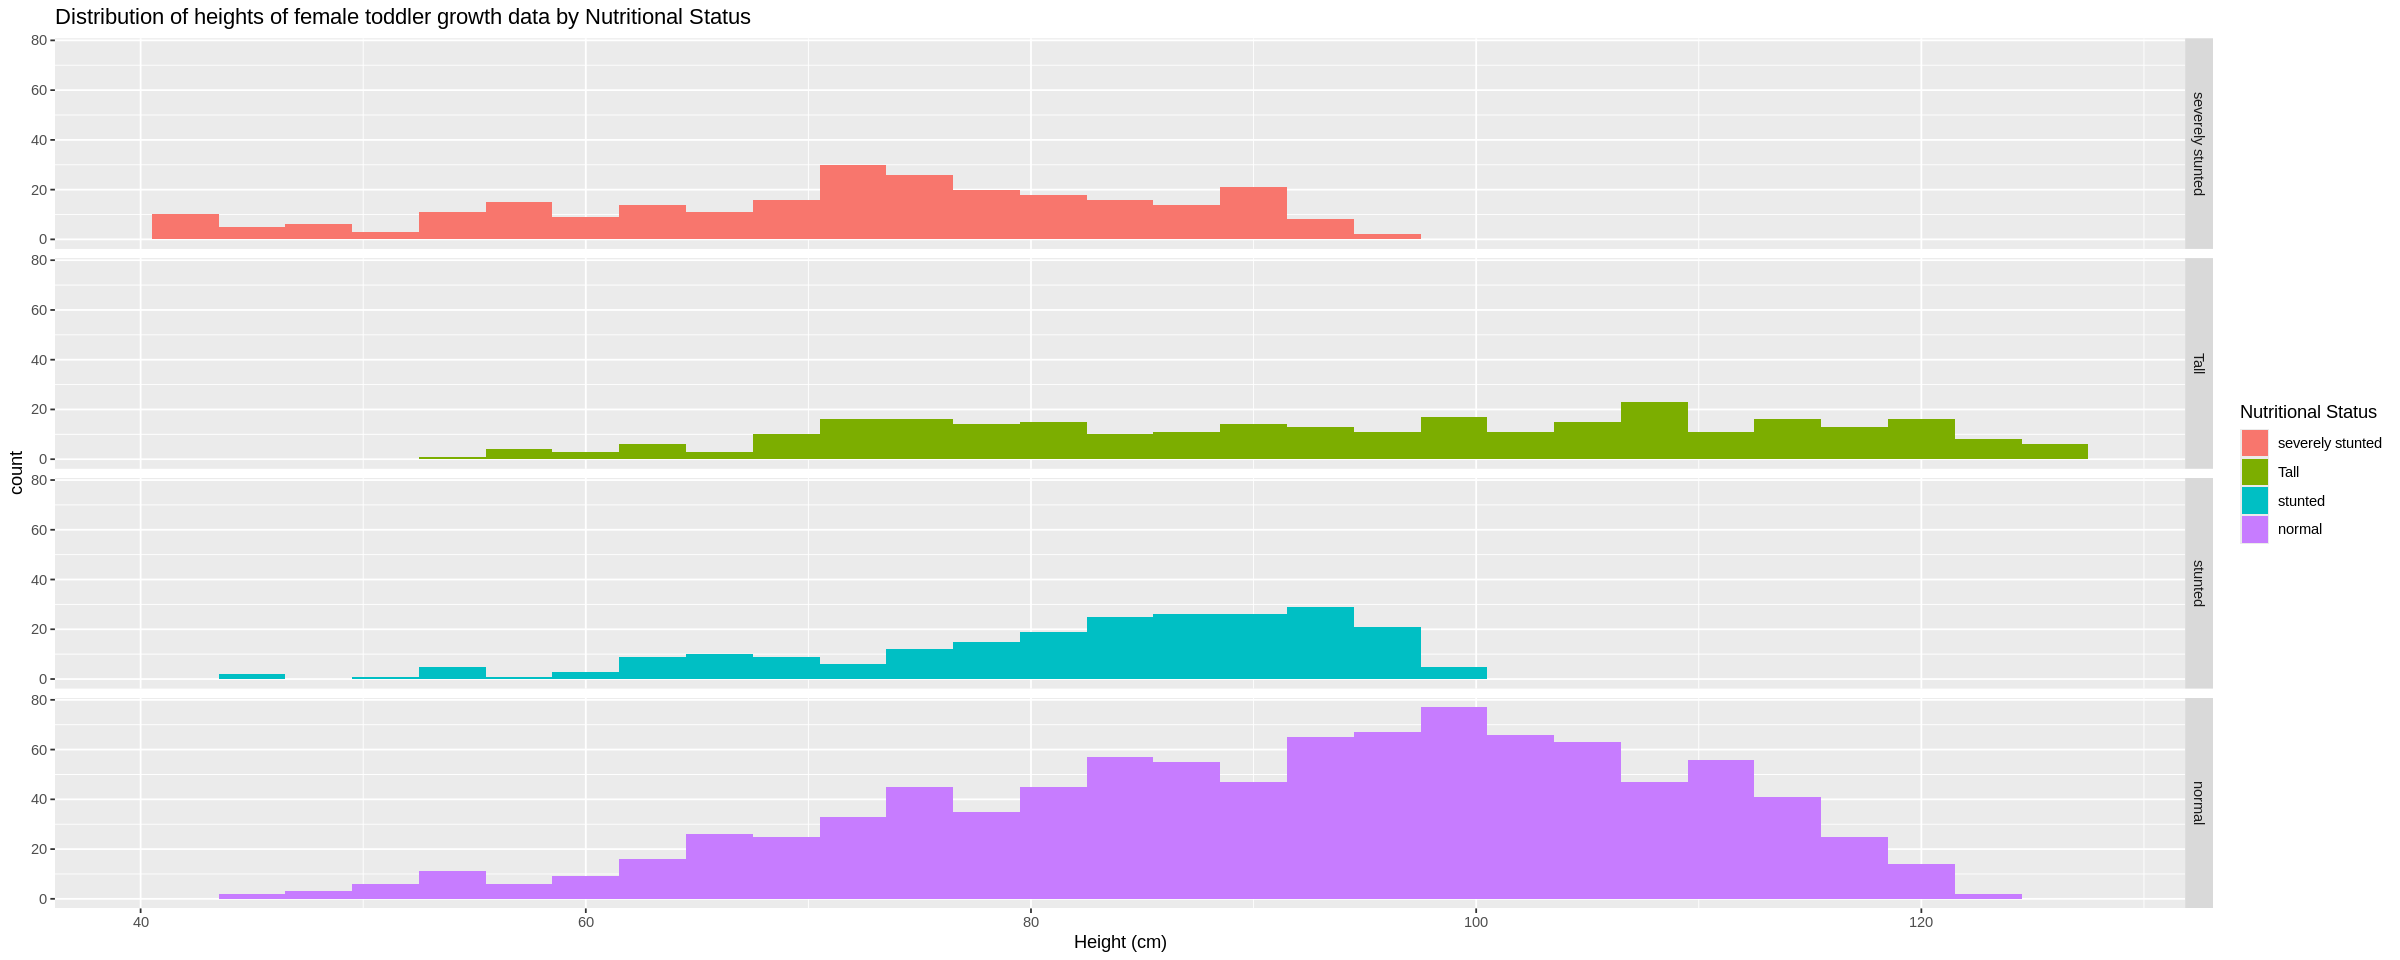

In [14]:
#Histogram of the data distribution.

female_growth_data_hist <- ggplot(growth_data_fem_train, aes(x = Height_cm, fill = as_factor(Nutritional_Status))) +
  geom_histogram(binwidth = 3) +
  facet_grid(rows = vars(Nutritional_Status))+
labs(x = "Height (cm)", fill = "Nutritional Status") +
ggtitle("Distribution of heights of female toddler growth data by Nutritional Status")

female_growth_data_hist

**Bar Plot depicting the distribution by age and nutrition status.**

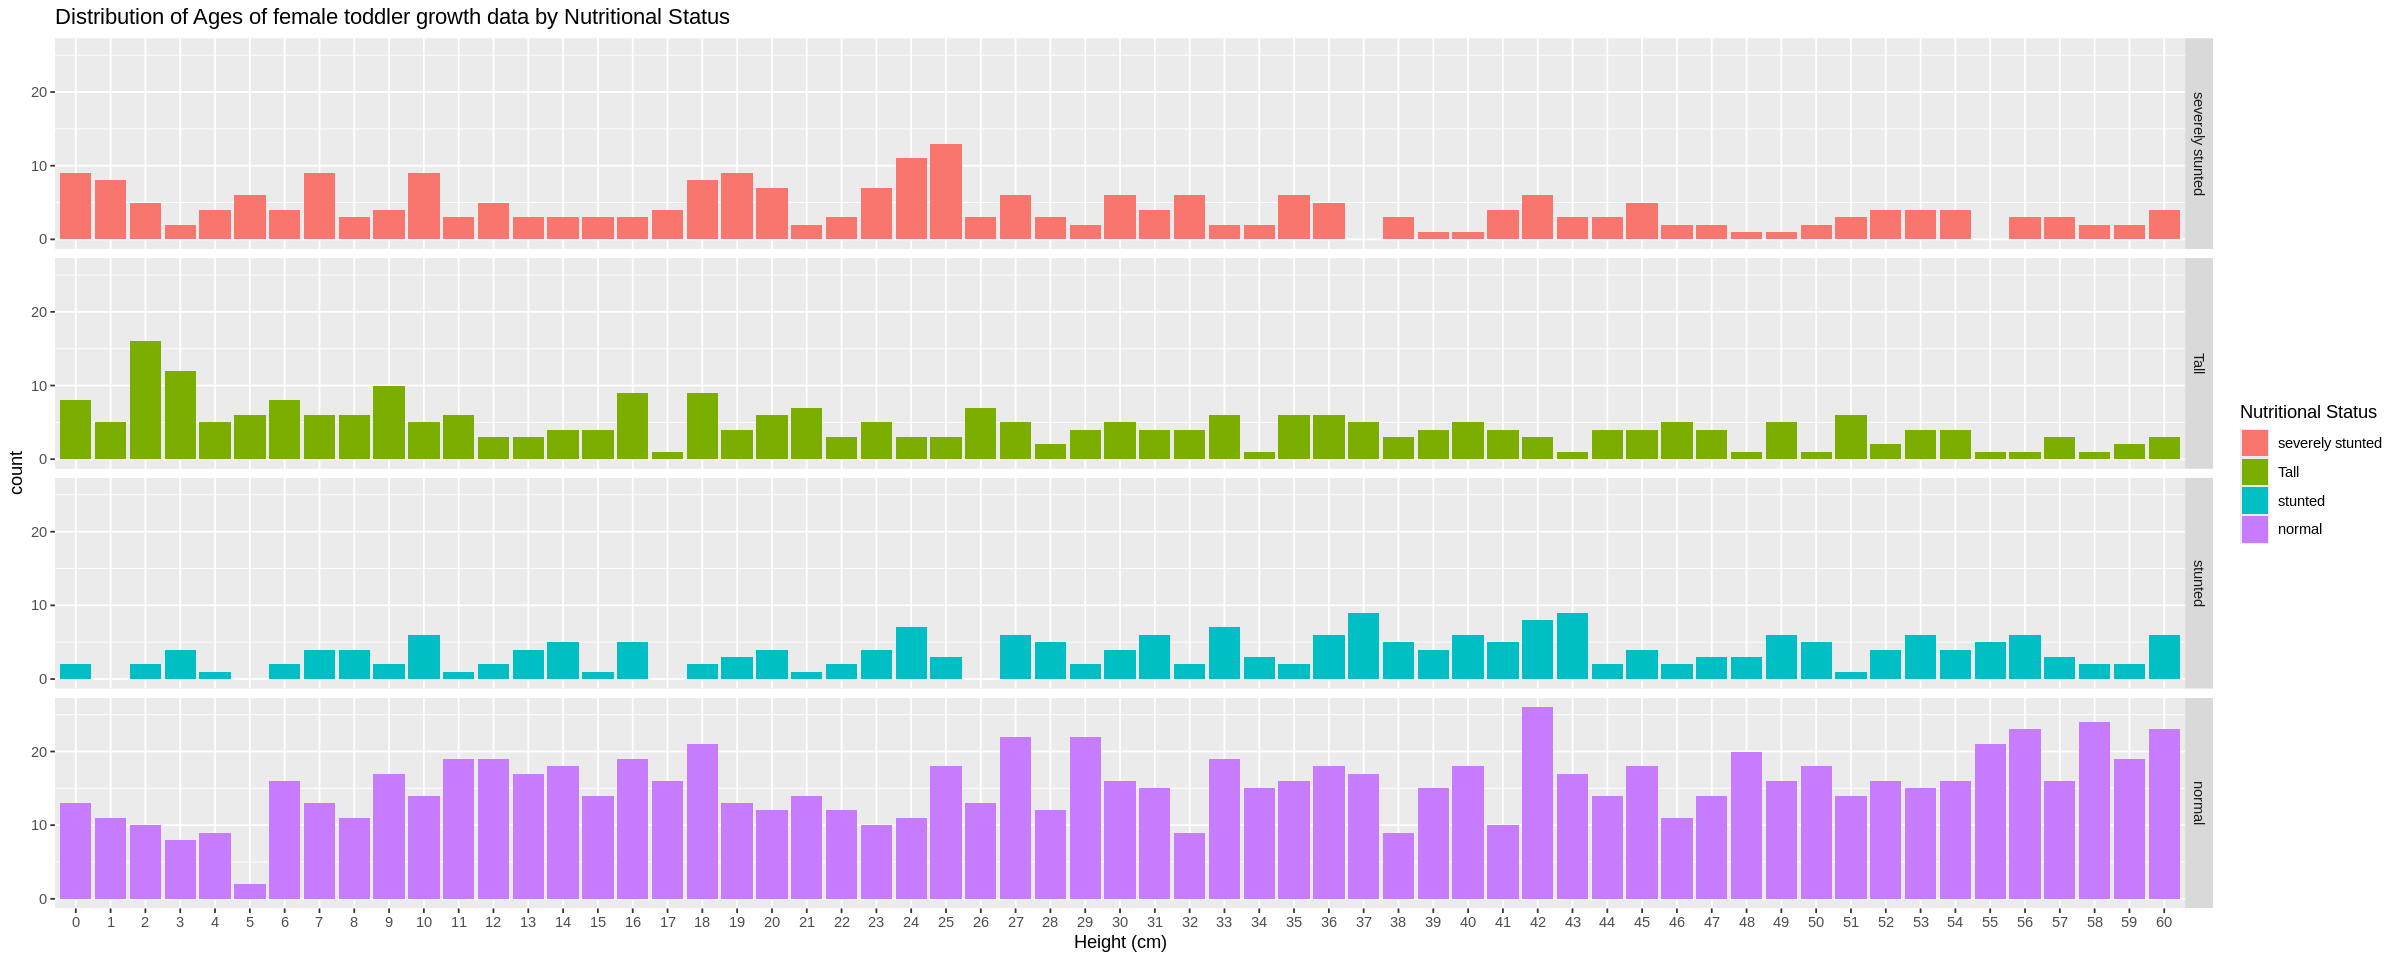

In [15]:
#Bar Plot depicting the distribution by age and nutrition status.
female_growth_data_bar <- ggplot(growth_data_fem_train, aes(x = as_factor(Age_Months), fill = as_factor(Nutritional_Status))) +
  geom_bar() +
  facet_grid(rows = vars(Nutritional_Status))+
labs(x = "Height (cm)", fill = "Nutritional Status") +
ggtitle("Distribution of Ages of female toddler growth data by Nutritional Status")


female_growth_data_bar

In [16]:
#Performing Cross Validation to assess the classifier's performance for different K values.

female_growth_vfold = vfold_cv(growth_data_fem_train, v = 7, strata = Nutritional_Status)
female_growth_vfold

splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [17]:
# Tuning the knn_spec and obtaining performance metrics for the classifier for different K values.
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#This creates a sequence of neighbor values for k from 1 to 50.
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |>
  add_recipe(growth_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = female_growth_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")


accuracies

neighbors .metric  .estimator mean      n std_err     .config              
1  1         accuracy multiclass 0.9531004 7 0.003455982 Preprocessor1_Model01
2  2         accuracy multiclass 0.9536883 7 0.003435524 Preprocessor1_Model02
3  3         accuracy multiclass 0.9507560 7 0.004027232 Preprocessor1_Model03
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮           ⋮                    
48 48        accuracy multiclass 0.8639540 7 0.008707109 Preprocessor1_Model48
49 49        accuracy multiclass 0.8557596 7 0.006927909 Preprocessor1_Model49
50 50        accuracy multiclass 0.8540031 7 0.007116159 Preprocessor1_Model50

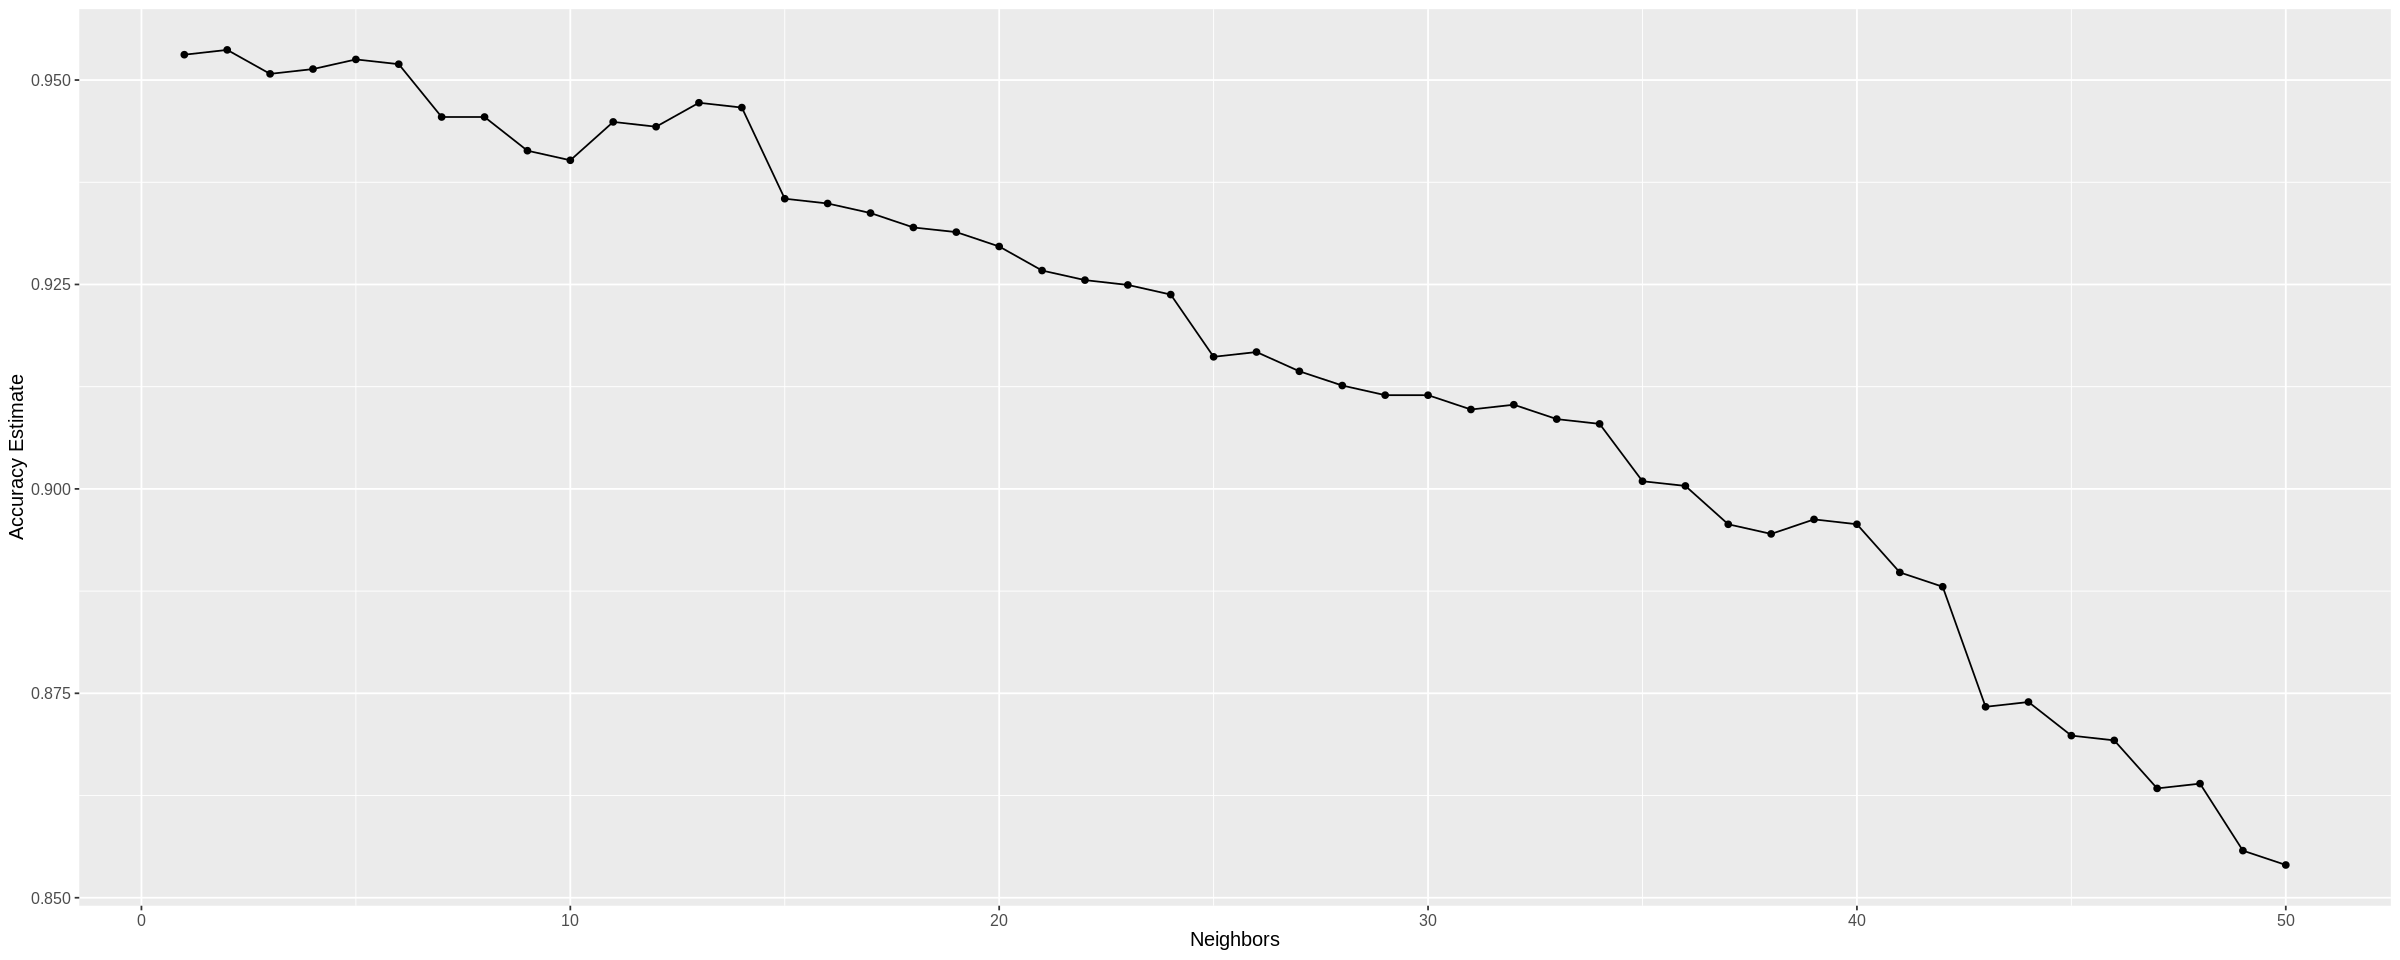

In [18]:
# A plot for K vs accuracy of the classifier is used to visualy analyze the relation and get a rough estimate
#of what the K value could be.
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [19]:
#We obtain the best possible candidates that can be used as K in our classifier.
best_ks <- accuracies |>
        arrange(desc(mean)) |>
        head(12) |>
        pull(mean,neighbors)
best_ks

2         1         5         6         4         3        13        14 
0.9536883 0.9531004 0.9525222 0.9519391 0.9513439 0.9507560 0.9472215 0.9466336 
        7         8        11        12 
0.9454795 0.9454795 0.9448796 0.9442917

In [20]:
#After choosing the appropriate k value, we train the classifier.
growth_recipe <- recipe(Nutritional_Status ~ Height_cm + Age_Months, data = growth_data_fem_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(growth_recipe) |>
  add_model(knn_spec) |>
  fit(data = growth_data_fem_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(14,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.05920281
Best kernel: rectangular
Best k: 14

In [21]:
#We test the classifier using the testing dataset and obtain performance metrics.
fem_growth_test_predictions <- predict(knn_fit, growth_data_fem_test) |>
  bind_cols(growth_data_fem_test)

fem_growth_test_predictions |>
  metrics(truth = Nutritional_Status, estimate = .pred_class) |>
  filter(.metric == "accuracy")

fem_growth_test_predictions |>
    precision(truth = Nutritional_Status, estimate = .pred_class, event_level="first")


fem_growth_test_predictions |>
    recall(truth = Nutritional_Status, estimate = .pred_class, event_level="first")

.metric  .estimator .estimate
1 accuracy multiclass 0.9373297

.metric   .estimator .estimate
1 precision macro      0.9277398

.metric .estimator .estimate
1 recall  macro      0.916918

In [22]:
#We can assess the accuracy of the classifier while predicting each of the classes.
pred_cm <- fem_growth_test_predictions |>
             conf_mat(truth = Nutritional_Status, estimate = .pred_class)
pred_cm

                  Truth
Prediction         severely stunted Tall stunted normal
  severely stunted              105    0       6      3
  Tall                            0  109       0      7
  stunted                         5    0      82      4
  normal                          0   13       8    392

## Methods:
**1. Cleaning up the data**
* Translate all non-English values in the raw data set into English
* Filter out the data set by the sex variable so only female observations are left.

**2. Separating the training data set and test data set**
* Set a specific seed for the random split of our data set into the training data set and test data set, so the data analysis process can be reproduced.
* Using initial_split, randomly divide the data set into a training set and a testing set by 70% to 30% ratio.
  
**3. Preprocessing (scaling) the training data set**
* Create a recipe for scaling and centering of the training data set using recipe, step_scale, and step_center

**4. Training the classifier**
* Determine the appropriate number of K for the nearest neighbor method for this data set.
* Set the engine and mode for specification
* Create a workflow for fitting by adding the recipe and the model

**5. Presenting the data**
* Create a scatter plot of the test data set, where the four different statuses of nutrition are shown in four different colors.
* More scatterplots that compare the training data set, and overlay of those two.

**6. Analysis and evaluation of our prediction**
* Compared to the actual nutritional status of test data set observations, evaluate the precision, recall, and accuracy of our prediction model.
* Reflect on our model such as the number of K, using the cross-validation method
* Think about the real-life implications of the data and the conclusion that can be drawn from its analysis, then reflect and determine what kind of predictive model would suit best.


## Expected Outcomes and Significance:
We predict that within the same age group, a female child with lower weight and height is more likely to be classified as stunted, and vice versa. A noticeable relationship between age, weight, height, and nutritional status is significant enough for us to establish a reliable prediction model to classify a female child’s nutritional status into four categories. 


Stunted growth can be detected quickly and early when establishing a model that predicts the nutritional status of female children. This is important because stunted growth in the early stage of a child’s life has a significant long-lasting effect on their growth, and early prediction enables appropriate nutritional or medical intervention before it is too late.


As growth depends on factors more than height and age, this study could be further conducted with more variables to create a more holistic understanding of factors that influence growth. This may include ethnicity, genetics, diseases, medical infrastructure, or socioeconomic status.


## Citations 
World Health Organization. (2015, November 19). Stunting in a Nutshell. World Health Organization. https://www.who.int/news/item/19-11-2015-stunting-in-a-nutshell#:~:text=Stunting%20is%20the%20impaired%20growth,WHO%20Child%20Growth%20Standards%20median 